Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 0.1604 - val_loss: 0.0981
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0886 - val_loss: 0.0620
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0501 - val_loss: 0.0111
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0028 - val_loss: 0.0027
Ep

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 787ms/step
Normal Brushes:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


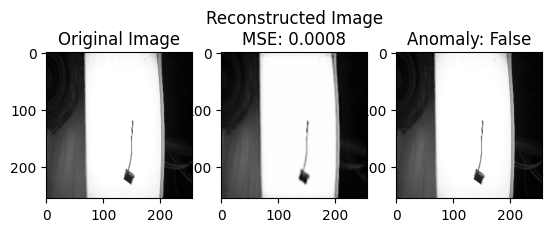

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


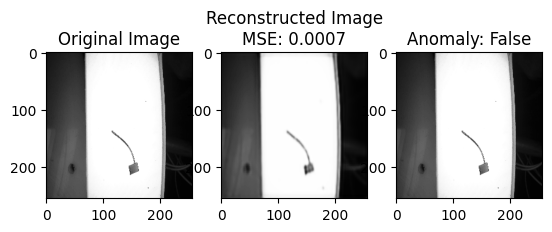

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


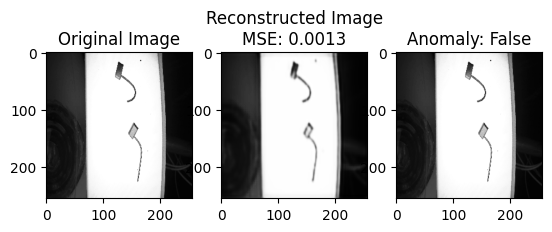

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


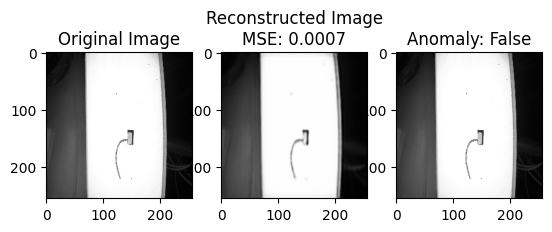

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


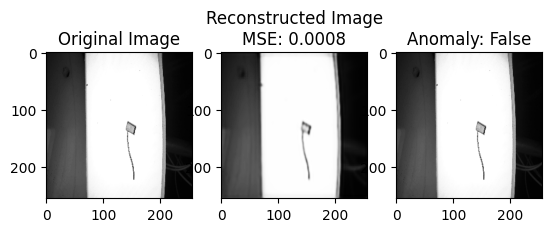

Defective Brushes:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


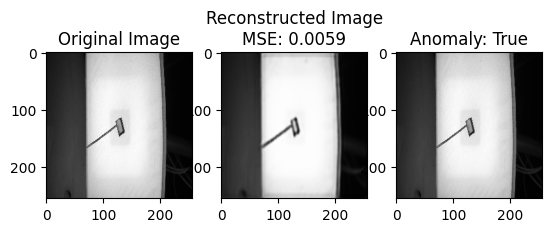

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


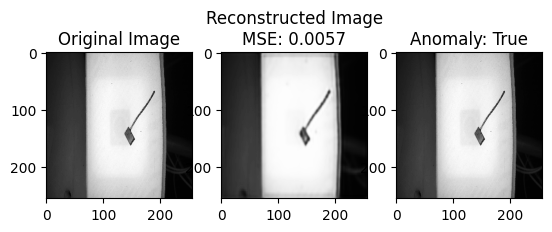

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


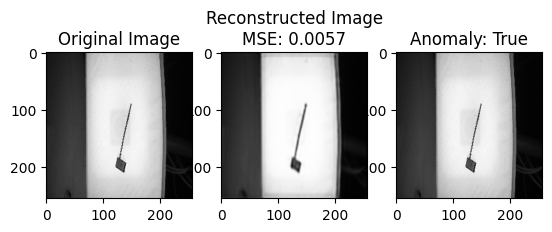

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


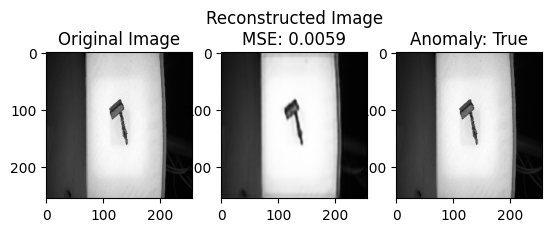

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


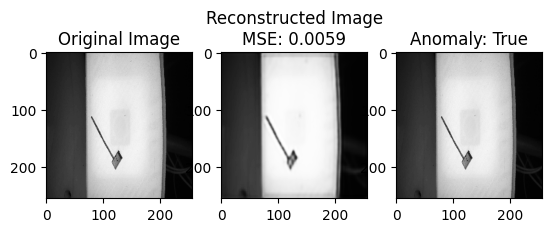

In [ ]:
import numpy as np
import cv2
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256

# Paths to the ZIP folders
normal_data_zip = '/content/data (2).zip'  # Path to zip file for normal carbon brushes (data(2))
defect_data_zip = '/content/carbon brush with defect.zip'  # Path to zip file for defective carbon brushes (carbon brush with defect)

# Temporary directories to extract the zip contents
normal_data_dir = 'normal_data_extracted'
defect_data_dir = 'defect_data_extracted'

# 1. Unzip the folders
def unzip_folder(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping normal and defective brush datasets
unzip_folder(normal_data_zip, normal_data_dir)
unzip_folder(defect_data_zip, defect_data_dir)

# 2. Preprocessing: Load and preprocess images
def load_images_from_folder(folder, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for root, _, files in os.walk(folder):
        for file in files:
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_width, img_height))  # Resize to standard dimensions
                img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
    return np.array(images)

# Load normal images (training data)
normal_images = load_images_from_folder(normal_data_dir)
normal_images = np.reshape(normal_images, (normal_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))

# Load defective images (for evaluation)
defect_images = load_images_from_folder(defect_data_dir)
defect_images = np.reshape(defect_images, (defect_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))

# 3. Build Convolutional Autoencoder (CAE)
def build_autoencoder(img_height, img_width):
    input_img = Input(shape=(img_height, img_width, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    return autoencoder

# Build and compile the autoencoder
autoencoder = build_autoencoder(IMG_HEIGHT, IMG_WIDTH)
autoencoder.compile(optimizer=Adam(), loss='mse')

# 4. Train the model
autoencoder.fit(normal_images, normal_images, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

# 5. Save the trained model
autoencoder.save('carbon_brush_autoencoder.h5')

# 6. Anomaly Detection: Reconstruction Error with Dynamic Threshold
def detect_anomalies(autoencoder, test_images, threshold=0.02):
    reconstructions = autoencoder.predict(test_images)
    mse = np.mean(np.power(test_images - reconstructions, 2), axis=(1, 2, 3))
    return mse > threshold, mse  # Return anomaly flags and the MSE values

# Calculate a dynamic threshold based on normal images' MSE
normal_flags, normal_mse = detect_anomalies(autoencoder, normal_images)
dynamic_threshold = np.mean(normal_mse) + 3 * np.std(normal_mse)

# Apply the dynamic threshold to detect anomalies
normal_flags, normal_mse = detect_anomalies(autoencoder, normal_images, threshold=dynamic_threshold)
defect_flags, defect_mse = detect_anomalies(autoencoder, defect_images, threshold=dynamic_threshold)

# 7. Visualize the Results: Defective vs. Normal
def visualize_anomalies(test_images, flags, mse_values, num_samples=5):
    for i in range(num_samples):
        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(test_images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title(f"Reconstructed Image\nMSE: {mse_values[i]:.4f}")
        reconstructed = autoencoder.predict(np.expand_dims(test_images[i], axis=0))
        plt.imshow(reconstructed.reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title(f"Anomaly: {flags[i]}")
        plt.imshow(test_images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
        plt.show()

# Visualize normal images (should be reconstructed well)
print("Normal Brushes:")
visualize_anomalies(normal_images, normal_flags, normal_mse, num_samples=5)

# Visualize defective images (should have high reconstruction errors)
print("Defective Brushes:")
visualize_anomalies(defect_images, defect_flags, defect_mse, num_samples=5)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Ground truth labels: 0 for normal brushes, 1 for defective brushes
y_true_normal = np.zeros(normal_images.shape[0])
y_true_defect = np.ones(defect_images.shape[0])
y_true = np.concatenate([y_true_normal, y_true_defect])

# 2. Predicted labels from the model
normal_predictions = normal_flags.astype(int)
defect_predictions = defect_flags.astype(int)
y_pred = np.concatenate([normal_predictions, defect_predictions])

# 3. Calculate evaluation metrics with zero_division handling
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# 4. Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9869
Precision: 0.9390
Recall: 1.0000
F1 Score: 0.9686
Confusion Matrix:
[[300   5]
 [  0  77]]
